# Split operator example of use
In this file, one will try to present how we can work with the split operator to simulate the KRAKEN experiment.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [ ]:
# Paramètres
x = np.linspace(-200, 200, 2048)        # in a.u. => in bohr units
dx = x[1] - x[0]
dt = 0.05
t = np.arange(0, 10, dt)                # also in a.u. => roughly 24as
N = len(x)
k = np.fft.fftfreq(N, d=dx) * 2 * np.pi

In [12]:
freq = 0.1  # Fréquence en Hz
champE_func = lambda x, t: np.cos(2 * np.pi * freq * t)
champE = champE_func(x[:, None], t)  # Champ électrique en fonction de x et t
print(champE)

[ 1.00000000e+00  9.99506560e-01  9.98026728e-01  9.95561965e-01
  9.92114701e-01  9.87688341e-01  9.82287251e-01  9.75916762e-01
  9.68583161e-01  9.60293686e-01  9.51056516e-01  9.40880769e-01
  9.29776486e-01  9.17754626e-01  9.04827052e-01  8.91006524e-01
  8.76306680e-01  8.60742027e-01  8.44327926e-01  8.27080574e-01
  8.09016994e-01  7.90155012e-01  7.70513243e-01  7.50111070e-01
  7.28968627e-01  7.07106781e-01  6.84547106e-01  6.61311865e-01
  6.37423990e-01  6.12907054e-01  5.87785252e-01  5.62083378e-01
  5.35826795e-01  5.09041416e-01  4.81753674e-01  4.53990500e-01
  4.25779292e-01  3.97147891e-01  3.68124553e-01  3.38737920e-01
  3.09016994e-01  2.78991106e-01  2.48689887e-01  2.18143241e-01
  1.87381315e-01  1.56434465e-01  1.25333234e-01  9.41083133e-02
  6.27905195e-02  3.14107591e-02  6.12323400e-17 -3.14107591e-02
 -6.27905195e-02 -9.41083133e-02 -1.25333234e-01 -1.56434465e-01
 -1.87381315e-01 -2.18143241e-01 -2.48689887e-01 -2.78991106e-01
 -3.09016994e-01 -3.38737

In [32]:
# Potentiel
epsilon = 0.1
V = -1.0 / np.sqrt(x**2 + epsilon)

In [33]:
# Initialisation de psi
psi = (1/np.pi**0.25) * np.exp(-x**2 / 2)
psi /= np.linalg.norm(psi) * np.sqrt(dx)

In [34]:
# Split-operator
def evolve(psi, V, E, dt):
    """
    Evolves the wavefunction psi by one time step using the split-operator method.

    The split-operator method is a numerical technique for solving the time-dependent Schrödinger equation.
    It exploits the fact that the Hamiltonian can be split into kinetic and potential parts, which are applied
    in alternating steps in position and momentum (Fourier) space. This allows efficient and accurate time evolution
    of quantum systems.

    Parameters
    ----------
    psi : np.ndarray
        The current wavefunction (array of complex values).
    V : np.ndarray
        The potential energy as a function of position.
    E : float or np.ndarray
        The electric field value (or array) at the current time step.
    dt : float
        The time step for evolution.

    Returns
    -------
    np.ndarray
        The evolved wavefunction after one time step.

    Principle
    ---------
    The time-evolution operator for a small time step dt is approximated as:
        U(dt) ≈ exp(-i V dt/2) exp(-i T dt) exp(-i V dt/2)
    where T is the kinetic energy operator. The kinetic part is applied in Fourier space,
    while the potential part is applied in position space. An additional phase from the electric field is included.
    """
    A = np.exp(-1j * V * dt / 2)
    B = np.exp(-1j * E * x * dt / 2)
    psi = B * psi
    psi = A * psi
    psi_k = np.fft.fft(psi)
    psi_k *= np.exp(-1j * (k**2) * dt / 2)
    psi = np.fft.ifft(psi_k)
    psi = A * psi
    psi = B * psi
    return psi

In [35]:
history = []
# Évolution
for En in champE:
    psi = evolve(psi, V, En, dt)
    rho = np.abs(psi)**2
    history.append(rho)


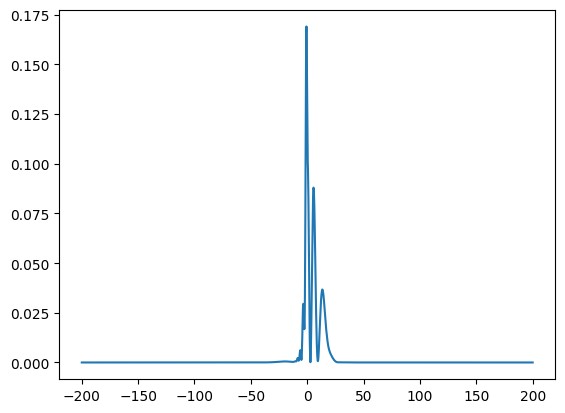

In [36]:
plt.plot(x, rho, label=f't={t[0]:.2f}s')
plt.show()

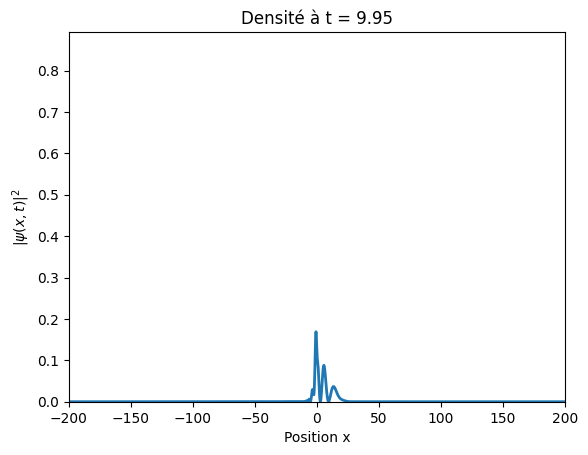

In [37]:
history = np.array(history)  # Transforme la liste en array 2D : shape (time, space)

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)

# Initialisation des limites du graphe
ax.set_xlim(x.min(), x.max())
ax.set_ylim(0, history.max() * 1.1)
ax.set_xlabel("Position x")
ax.set_ylabel(r"$|\psi(x,t)|^2$")
ax.set_title("Densité de probabilité")

# Fonction d'initialisation
def init():
    line.set_data([], [])
    return line,

# Mise à jour à chaque frame
def update(frame):
    line.set_data(x, history[frame])
    ax.set_title(f"Densité à t = {frame * dt:.2f}")
    return line,

# Animation
ani = FuncAnimation(fig, update, frames=len(history), init_func=init, blit=True)

# Affichage dans Jupyter
HTML(ani.to_jshtml())